In [1]:
import xarray as xr
import polars as pl
import glob
import pandas as pd
import re
from datetime import datetime
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

In [2]:
# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "MOLAR_DOXY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

# Add a 'glider_name' column by extracting the part before '_' in 'profile_id'
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 12)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 12)


In [3]:
def summarising_profiles(df: pl.DataFrame) -> pl.DataFrame:
    """
    Summarise profiles by taking the median of each variable for each profile_id.
    """
        # Group by 'profile_id' and 'glider_name', then aggregate median datetime, longitude, latitude
    summary = (
        df
        .group_by(['profile_id', 'glider_name'])
        .agg([
            pl.col('TIME').median().alias('median_datetime'),
            pl.col('LONGITUDE').median().alias('median_longitude'),
            pl.col('LATITUDE').median().alias('median_latitude')
        ])
        .sort('median_datetime')
    )
    summary = summary.to_pandas()
    return(summary)

In [4]:
def find_closest_prof(df_a, df_b):
    # Prepare arrays for glider and CTD profile locations and times
    glider_a_times = df_a['median_datetime'].values
    glider_a_lons = df_a['median_longitude'].values
    glider_a_lats = df_a['median_latitude'].values

    glider_b_times = df_b['median_datetime'].values
    glider_b_lons = df_b['median_longitude'].values
    glider_b_lats = df_b['median_latitude'].values
    glider_b_profile_ids = df_b['profile_id'].values
    # For each glider profile, find the closest CTD profile in time and compute distance
    closest_glider_b_profile = []
    closest_time_diff = []
    distance_km = []

    for g_time, g_lat, g_lon in zip(glider_a_times, glider_a_lats, glider_a_lons):
        # Find index of closest CTD profile in time
        time_diffs = abs(glider_b_times - g_time)
        idx = time_diffs.argmin()
        closest_glider_b_profile.append(glider_b_profile_ids[idx])
        closest_time_diff.append(time_diffs[idx])
        # Compute distance in km, handle nan coordinates
        glider_pos = (g_lat, g_lon)
        b_pos = (glider_b_lats[idx], glider_b_lons[idx])
        if np.isfinite(g_lat) and np.isfinite(g_lon) and np.isfinite(glider_b_lats[idx]) and np.isfinite(glider_b_lons[idx]):
            dist = geodesic(glider_pos, b_pos).km
        else:
            dist = np.nan
        distance_km.append(dist)

    # Add results to summary_pd
    df_a['closest_glider_b_profile'] = closest_glider_b_profile
    df_a['glider_b_time_diff'] = closest_time_diff
    df_a['glider_b_distance_km'] = distance_km
    result = df_a.copy()
    return result

In [ ]:
def plot_distance_ts(matchup_df, glider_ref, glider_comp):
    # Plot
    plt.figure(figsize=(12, 6))
    for name, group in matchup_df.groupby('glider_name'):
        plt.plot(group['median_datetime'], group['glider_b_distance_km'], label=name, marker='o', linestyle='-')

    plt.xlabel('Datetime')
    plt.ylabel('Distance to Closest CTD Profile (km)')
    plt.ylim(0, 50)
    plt.title(f'Distance between {glider_ref} and other{glider_comp} Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

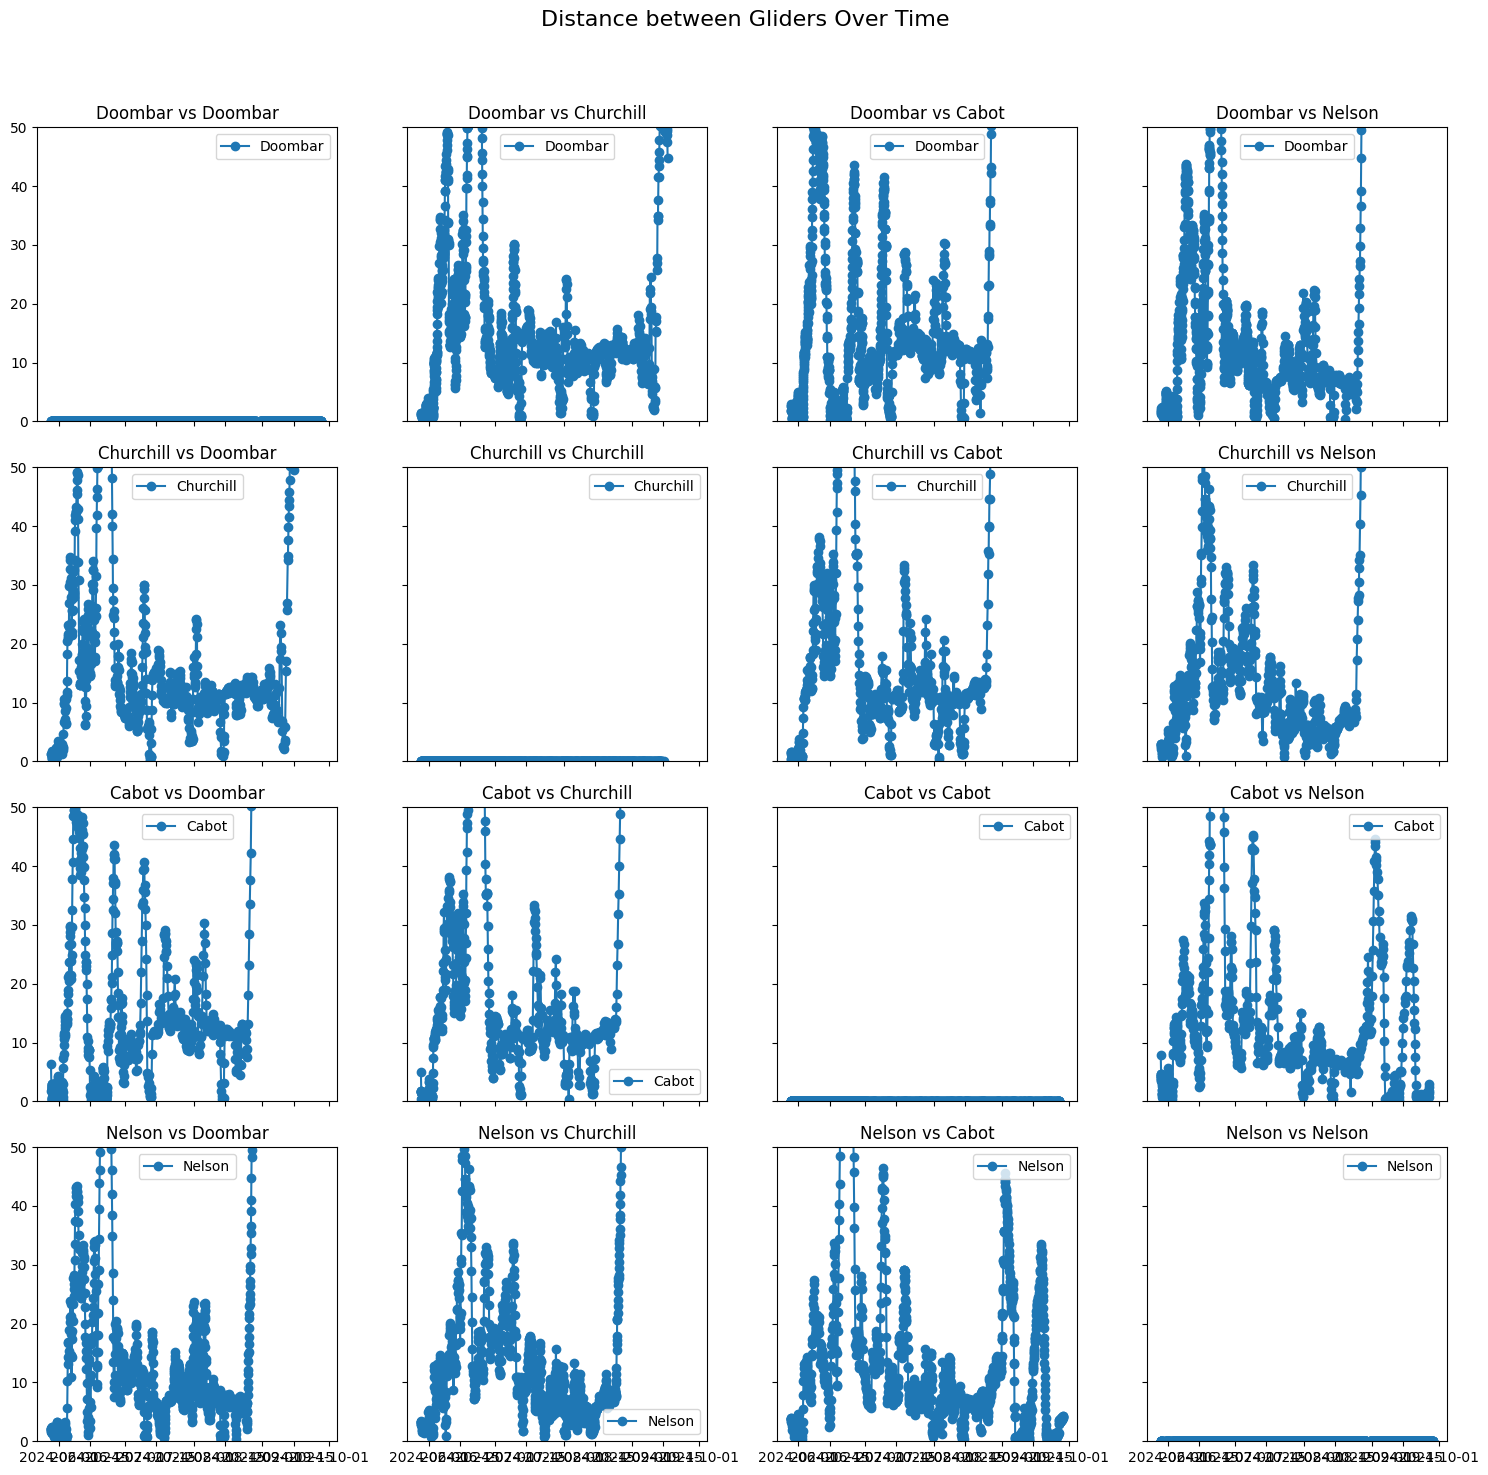

In [5]:
unique_gliders = df_concat['glider_name'].unique()
grid_size = len(unique_gliders)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle("Distance between Gliders Over Time", fontsize=16)

for i, g_id in enumerate(unique_gliders):
    for j, g_b_id in enumerate(unique_gliders):
        ref_df = df_concat.filter(pl.col("glider_name") == g_id)
        comp_df = df_concat.filter(pl.col("glider_name") == g_b_id)

        summary_ref = summarising_profiles(ref_df)
        summary_comp = summarising_profiles(comp_df)

        paired = find_closest_prof(summary_ref, summary_comp)

        ax = axes[i, j]
        for name, group in paired.groupby('glider_name'):
            ax.plot(group['median_datetime'], group['glider_b_distance_km'], label=name, marker='o', linestyle='-')

        ax.set_title(f"{g_id} vs {g_b_id}")
        ax.set_ylim(0, 50)
        ax.legend()

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("C:/Users/flapet/OneDrive - NOC/Documents/RISC_GLIDER_DEMO/Output/Plots/gliders_distance_over_time.png")
plt.show()


## Heatmap plotting 

In [13]:
import pandas as pd
from geopy.distance import geodesic

def find_candidate_glider_pairs(glider_a_df, glider_b_df, glider_a_name, glider_b_name, time_thresh_hr=2, dist_thresh_km=5):
    """
    Identify all pairs of glider and CTD profiles within specified time (hours) and distance (km) thresholds.
    
    Returns a DataFrame of matching pairs with details.
    """
    matches = []
    
    for _, g_row in glider_a_df.iterrows():
        for _, c_row in glider_b_df.iterrows():
            # Time difference
            time_diff_hr = abs((g_row['median_datetime'] - c_row['median_datetime']).total_seconds()) / 3600.0
            if time_diff_hr > time_thresh_hr:
                continue

            # Skip if coordinates are missing
            if pd.isnull(g_row['median_latitude']) or pd.isnull(g_row['median_longitude']) \
               or pd.isnull(c_row['median_latitude']) or pd.isnull(c_row['median_longitude']):
                continue

            # Distance in kilometers
            dist_km = geodesic(
                (g_row['median_latitude'], g_row['median_longitude']),
                (c_row['median_latitude'], c_row['median_longitude'])
            ).km

            if dist_km > dist_thresh_km:
                continue

            matches.append({
                'glider_a_profile_id': g_row['profile_id'],
                'glider_name': glider_a_name,
                'glider_b_profile_id': c_row.get('profile_id', None),  # default to None if not present
                'glider_b_name': glider_b_name,
                'time_diff_hr': time_diff_hr,
                'dist_km': dist_km
            })
    
    return pd.DataFrame(matches)

In [15]:
def plot_heatmap_glider_df(glider_matchup_df, time_bins, dist_bins, glider_a_name, glider_b_name):
    """
    Plot cumulative 2D histogram (heatmap) of matchups from a DataFrame for a specific glider.
    
    Parameters:
    - glider_name: str, the glider to filter
    - df: pd.DataFrame with required columns: 
          'glider_profile_id', 'glider_name', 'ctd_profile_id', 'time_diff_hr', 'dist_km'
    - time_bins: array-like, bin edges for time (in hours)
    - dist_bins: array-like, bin edges for distance (in km)
    """

    # Filter DataFrame for selected glider

    if glider_matchup_df.empty:
        print(f"No matchups found for glider '{glider_name}'.")
        return

    # Extract arrays for histogram
    time_diffs = glider_matchup_df['time_diff_hr'].values
    dist_kms = glider_matchup_df['dist_km'].values

    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(time_diffs, dist_kms, bins=[time_bins, dist_bins])

    # Cumulative sum along both axes
    H_cum = H.cumsum(axis=0).cumsum(axis=1)

    # Plot heatmap
    X, Y = np.meshgrid(yedges, xedges)
    plt.figure(figsize=(9, 7))
    plt.pcolormesh(X, Y, H_cum, cmap='PuBu', shading='auto')
    plt.colorbar(label='Cumulative Number of Matchups')
    plt.xlabel('Distance Threshold (km)')
    plt.ylabel('Time Threshold (hr)')
    plt.title(f'Cumulative Matchups by Time/Distance\nGlider: {glider_a_name} VS {glider_b_name}')

    # Annotate each cell with value
    for i in range(H_cum.shape[0]):
        for j in range(H_cum.shape[1]):
            val = int(H_cum[i, j])
            if val > 0:
                x_center = (yedges[j] + yedges[j+1]) / 2
                y_center = (xedges[i] + xedges[i+1]) / 2
                color = 'white' if val > H_cum.max() / 2 else 'black'
                plt.text(x_center, y_center, str(val), ha='center', va='center', fontsize=8, color=color)

    plt.tight_layout()
    plt.show()

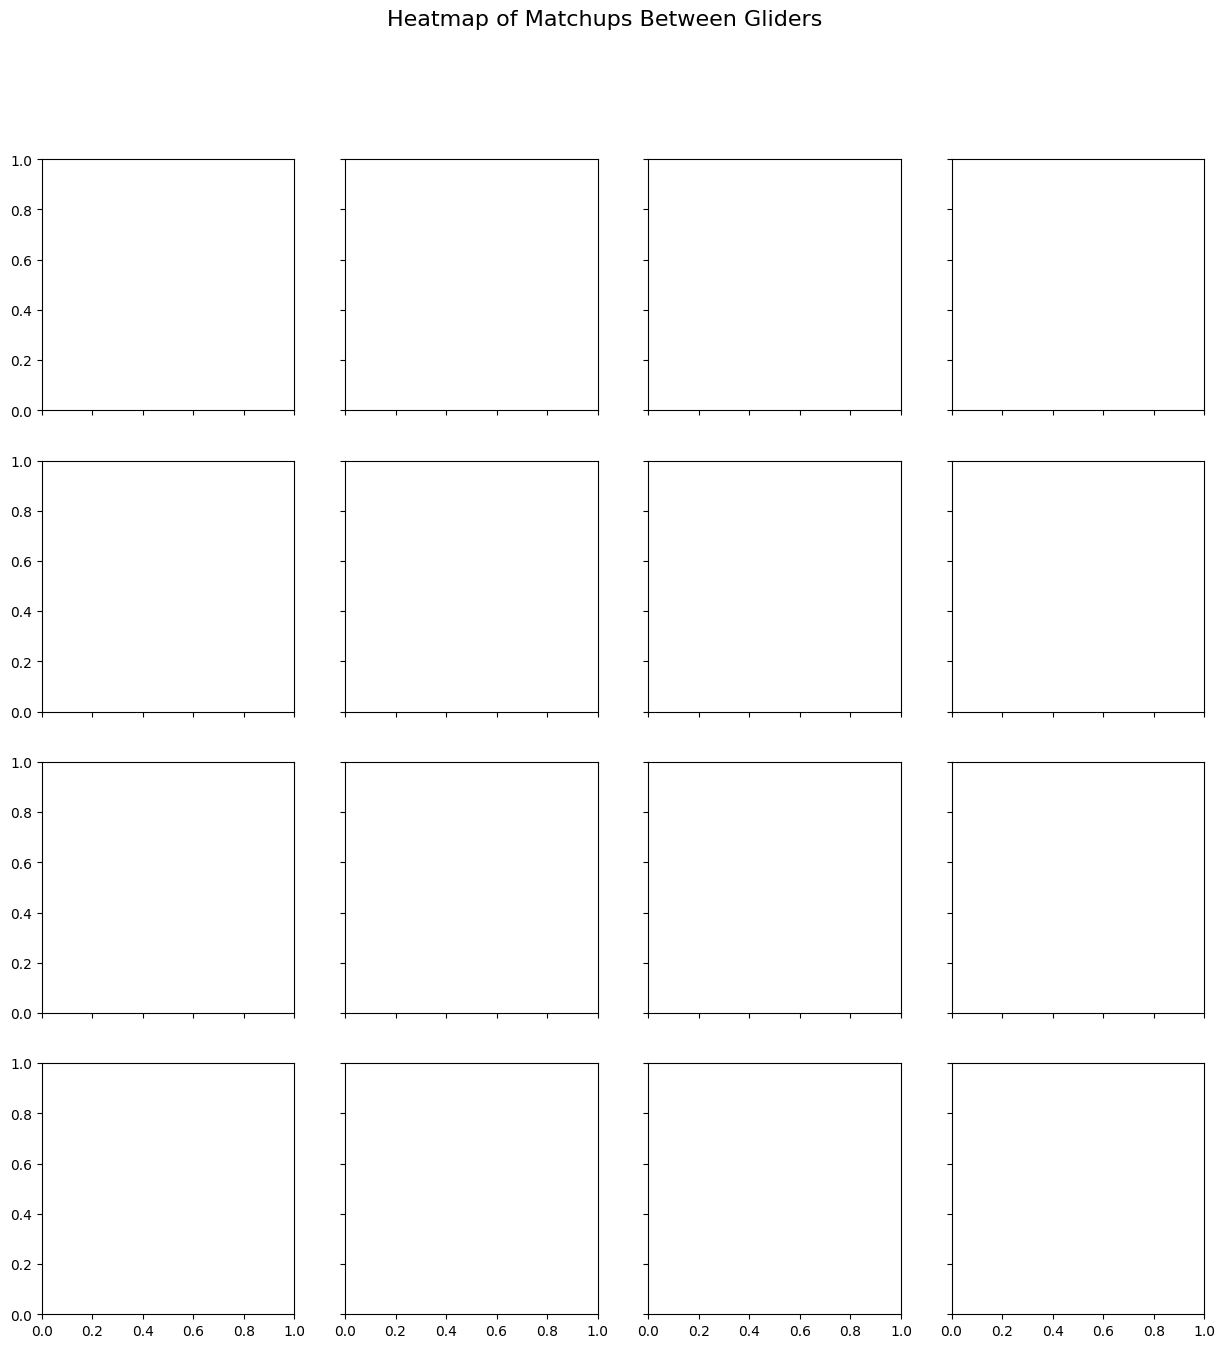

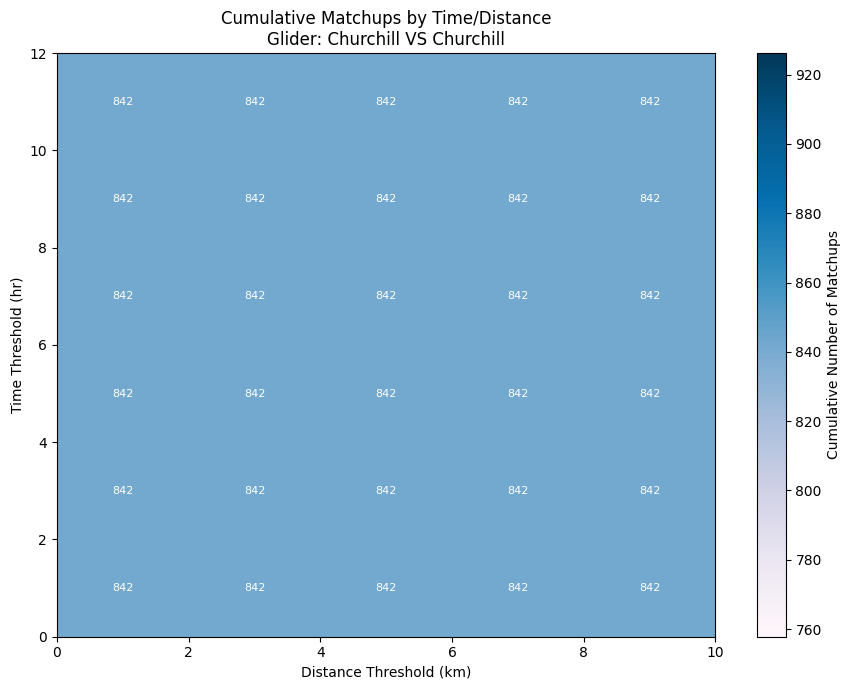

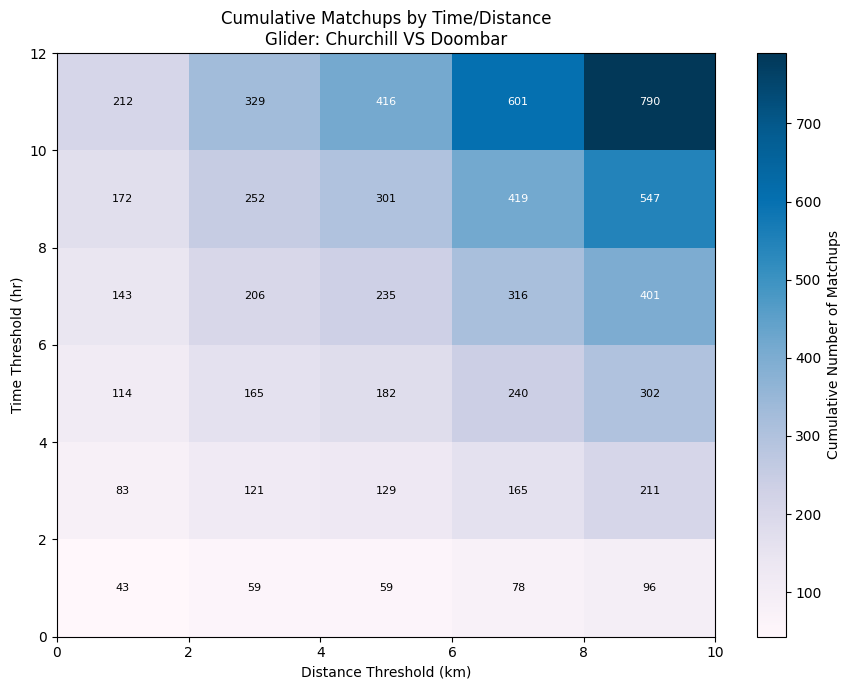

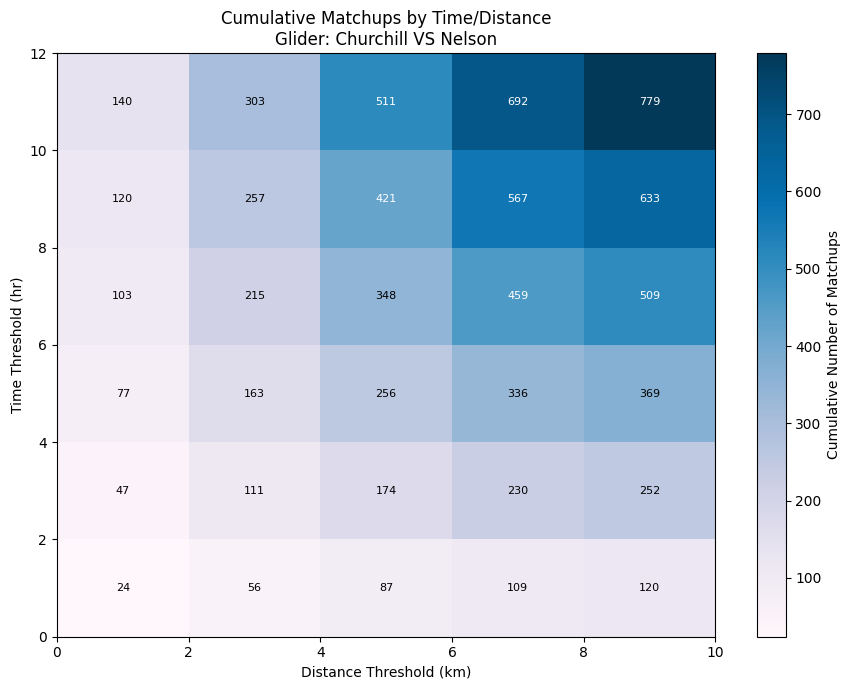

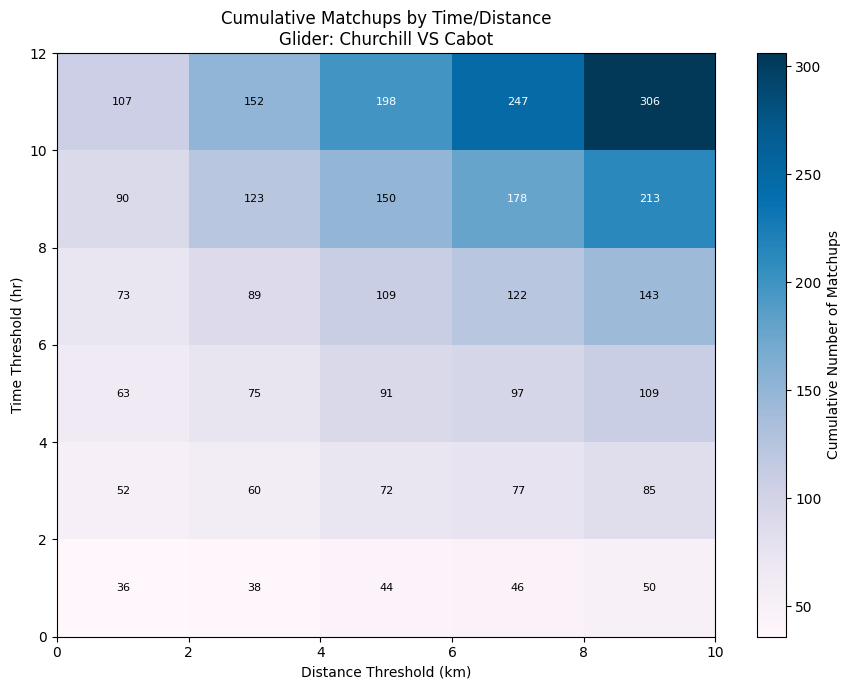

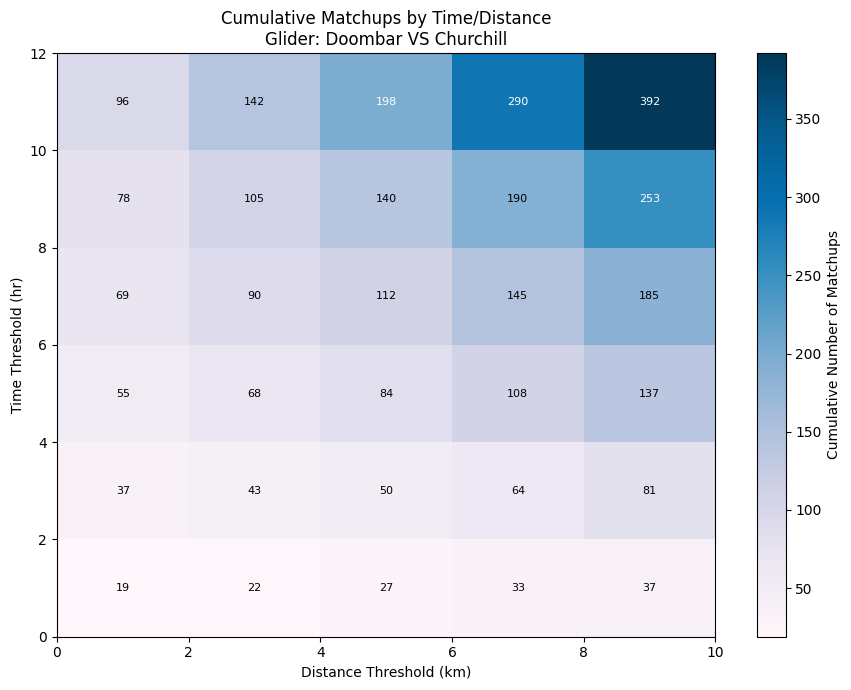

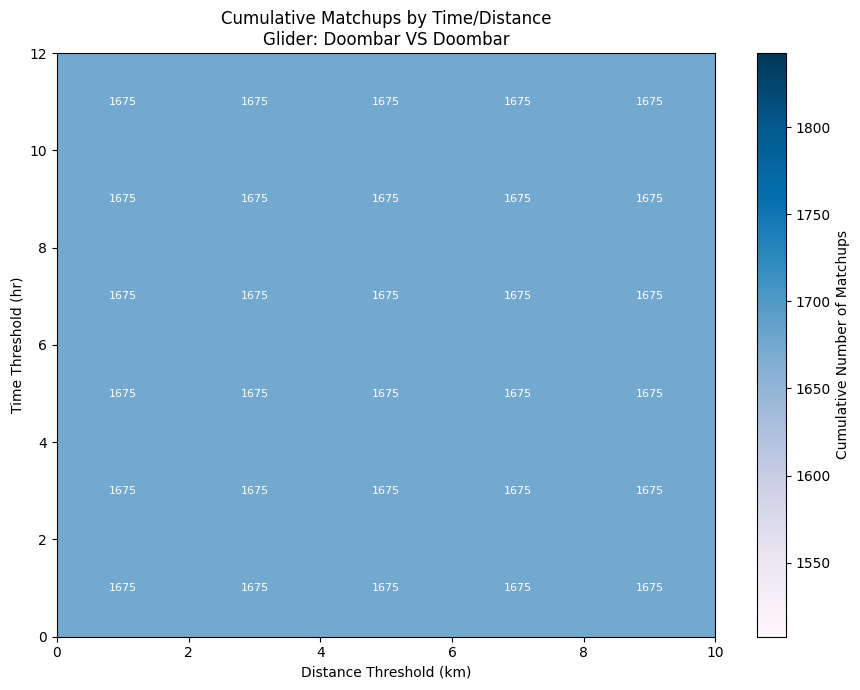

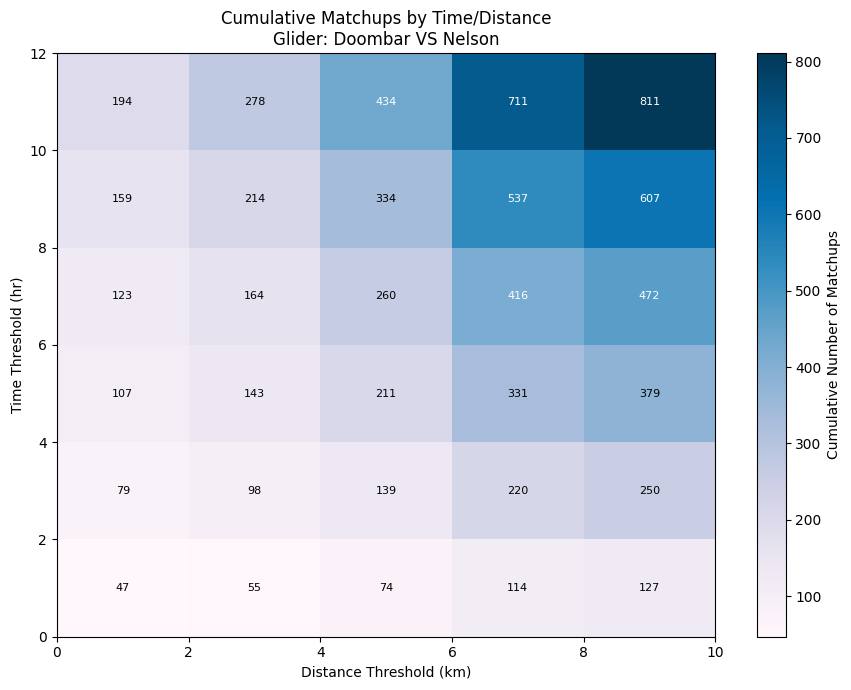

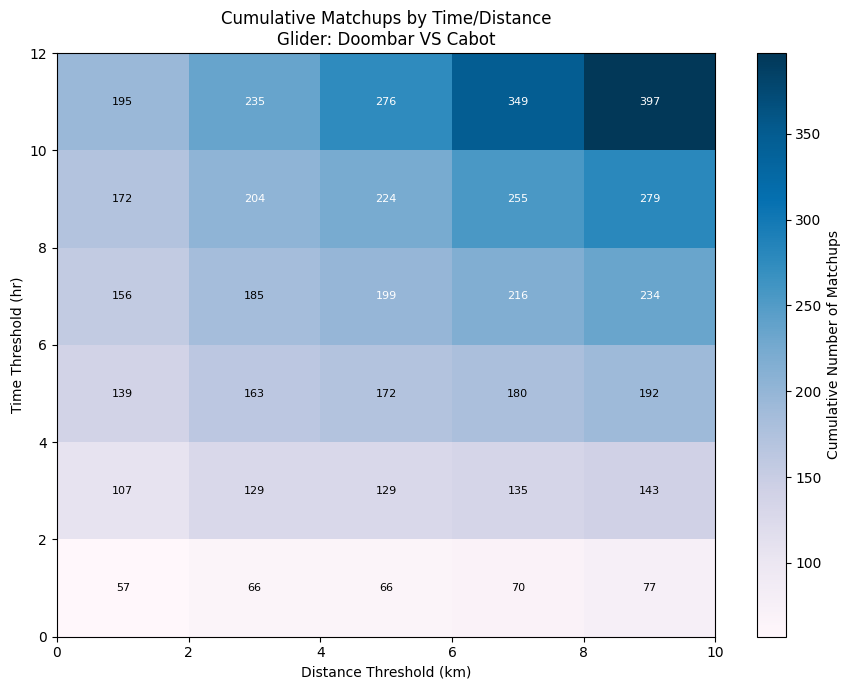

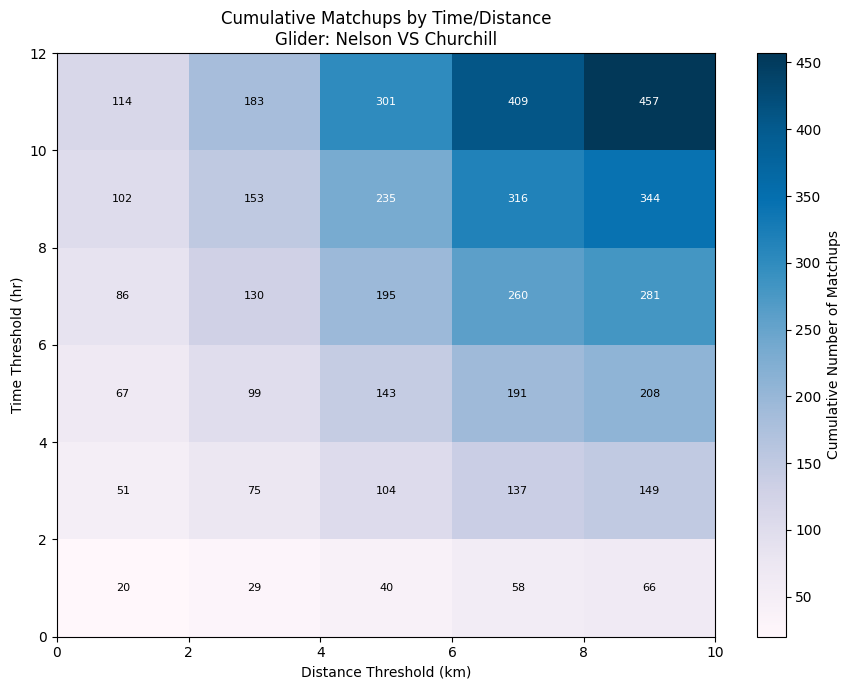

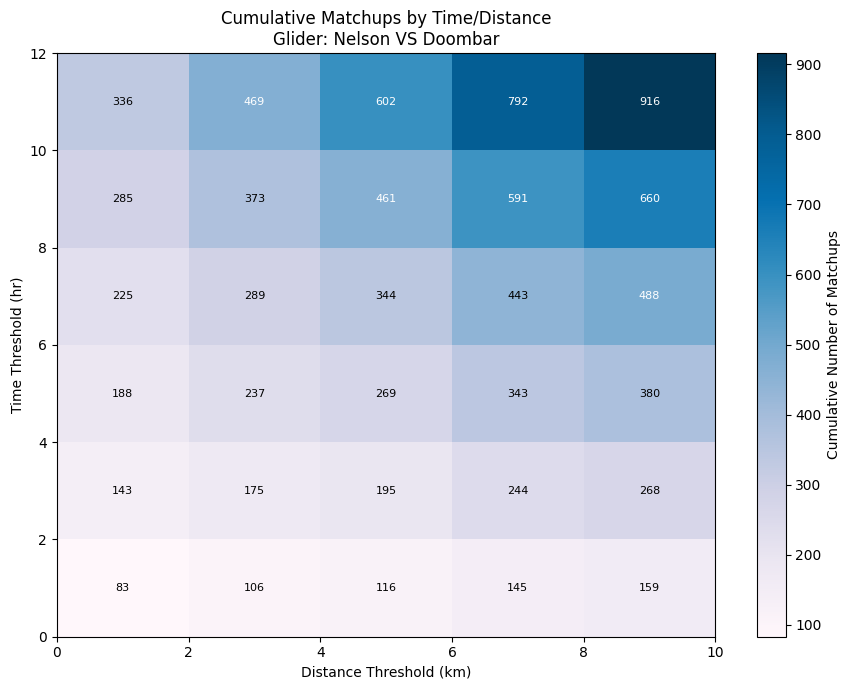

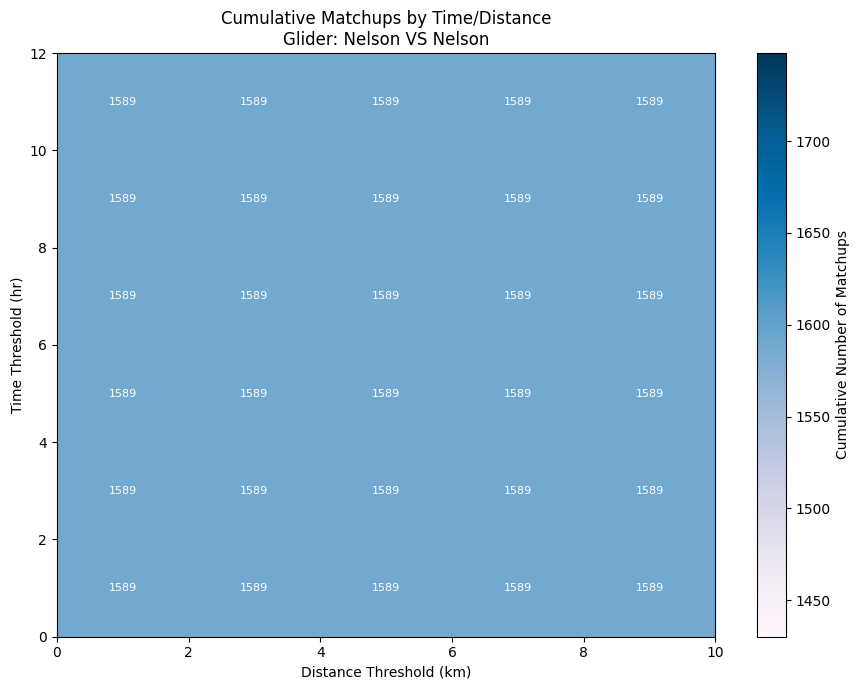

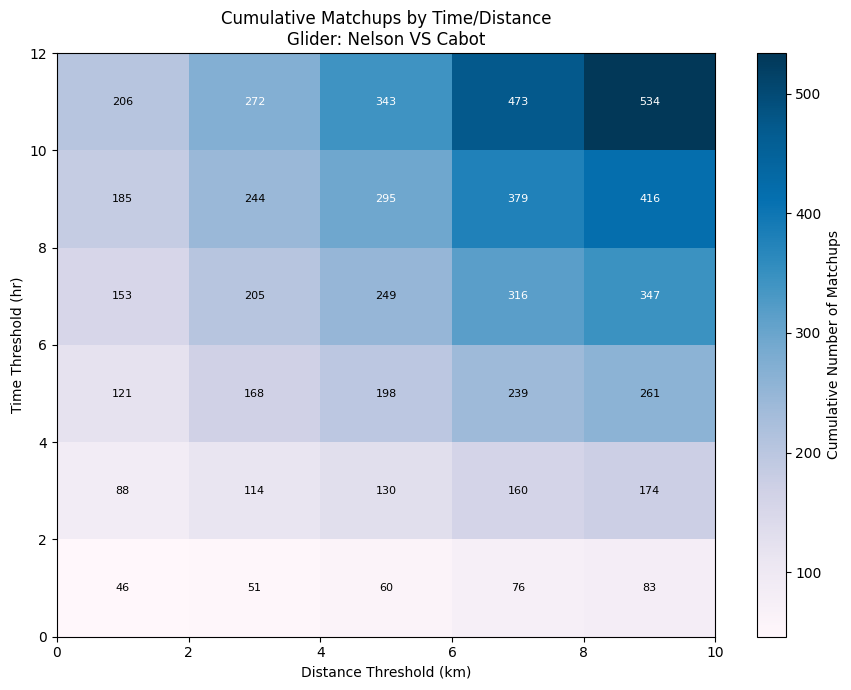

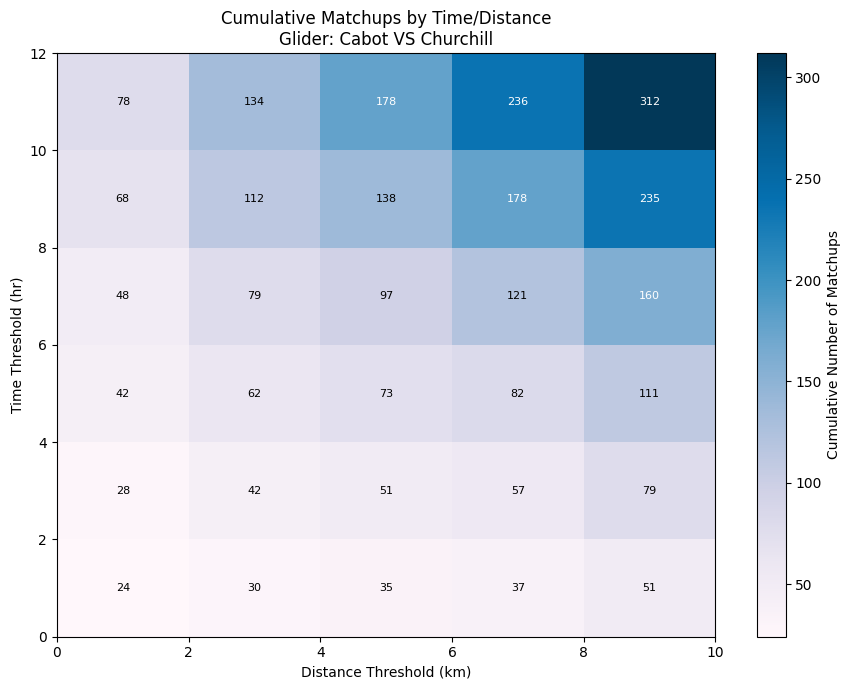

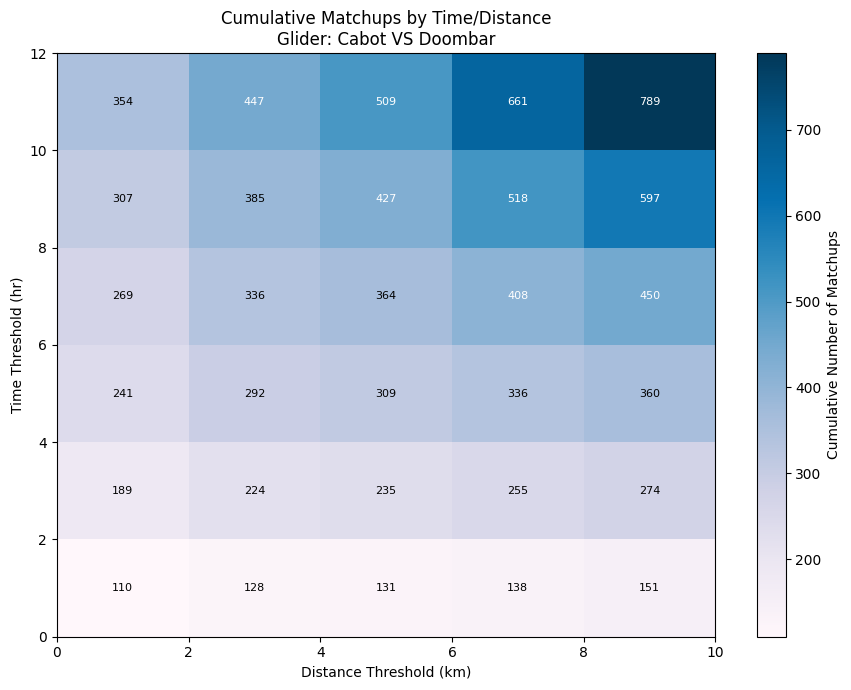

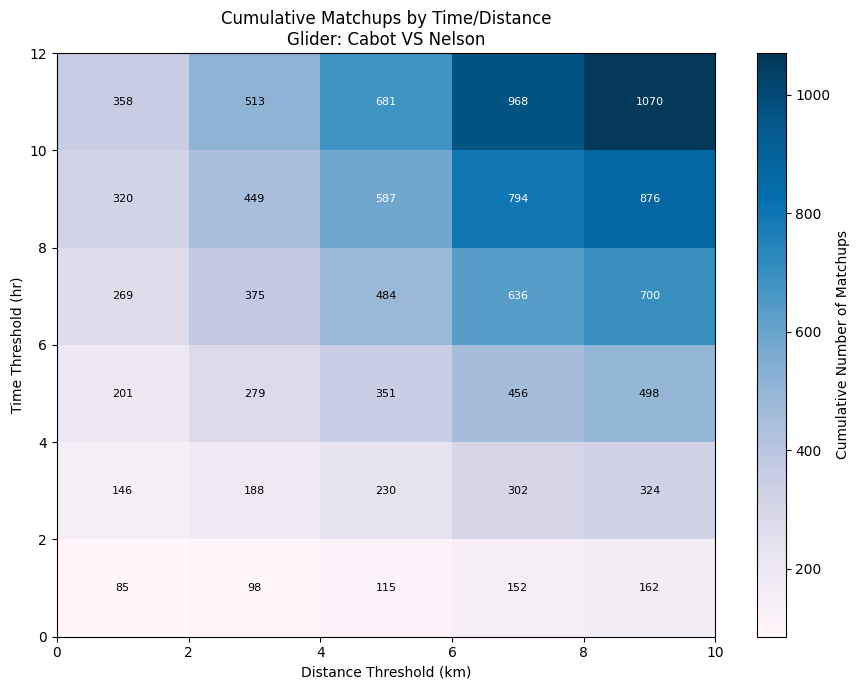

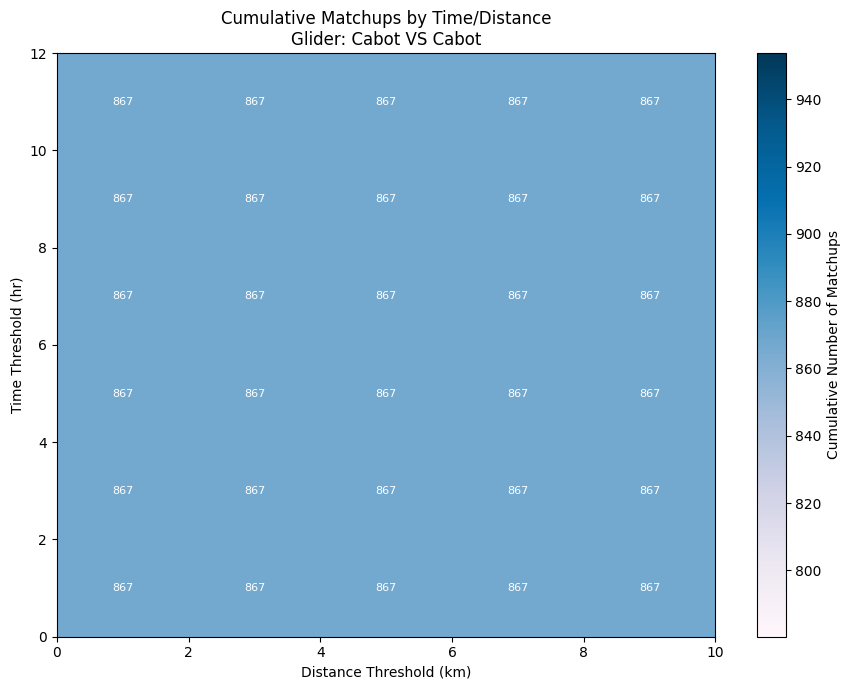

<Figure size 640x480 with 0 Axes>

In [16]:
unique_gliders = df_concat['glider_name'].unique()
grid_size = len(unique_gliders)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle("Heatmap of Matchups Between Gliders", fontsize=16)

for i, g_id in enumerate(unique_gliders):
    for j, g_b_id in enumerate(unique_gliders):
        ref_df = df_concat.filter(pl.col("glider_name") == g_id)
        comp_df = df_concat.filter(pl.col("glider_name") == g_b_id)

        summary_ref = summarising_profiles(ref_df)
        summary_comp = summarising_profiles(comp_df)

        candidates = find_candidate_glider_pairs(
            summary_ref,
            summary_comp,
            time_thresh_hr=12,
            dist_thresh_km=20,
            glider_a_name = g_id,
            glider_b_name = g_b_id)

        if not candidates.empty:
            filtered_candidates = candidates.loc[
                candidates.groupby('glider_b_profile_id')['dist_km'].idxmin()
            ].reset_index(drop=True)

            time_bins = np.arange(0, 13, 2)
            dist_bins = np.arange(0, 11, 2)

            ax = axes[i, j]
            plot_heatmap_glider_df(filtered_candidates, time_bins, dist_bins, g_id, g_b_id)
            ax.set_title(f"{g_id} vs {g_b_id}")

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("C:/Users/flapet/OneDrive - NOC/Documents/RISC_GLIDER_DEMO/Output/Plots/heatmap_matrices.png")
plt.show()
